In [67]:
!pip install gower
!pip install xgboost

   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 262.6 kB/s eta 0:06:20
   ---------------------------------------- 0.1/99.8 MB 469.7 kB/s eta 0:03:33
   ---------------------------------------- 0.1/99.8 MB 476.3 kB/s eta 0:03:30
   ---------------------------------------- 0.2/99.8 MB 807.1 kB/s eta 0:02:04
   ---------------------------------------- 0.3/99.8 MB 1.1 MB/s eta 0:01:34
   ---------------------------------------- 0.4/99.8 MB 1.3 MB/s eta 0:01:18
   ---------------------------------------- 0.5/99.8 MB 1.5 MB/s eta 0:01:07
   ---------------------------------------- 0.6/99.8 MB 1.6 MB/s eta 0:01:02
   ---------------------------------------- 0.7/99.8 MB 1.8 MB/s eta 0:00:57
   ---------------------------------------- 0.9/99.8 MB 1.9 MB/s eta 0:00:53
   ---------

In [95]:
import pandas as pd
import numpy as np
# visual
import matplotlib.pyplot as plt
import seaborn as sns
# distance
import gower
# sklearn
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, rand_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics


In [32]:
# Adjusted function to read and parse the .data file, ensuring -1 class is correctly handled
def load_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data = []
    current_class = None

    # Columns from the first line (removing the last two characters \n and space at the end)
    columns = lines[0].strip().split()
    columns.append('Class')  # Adding the 'Class' column for labels

    # Parse each line
    for line in lines[1:]:  # Start from the second line to skip header
        stripped_line = line.strip()
        if stripped_line.lstrip('-').isdigit():  # This is a class label, handles negative numbers
            current_class = int(stripped_line)
        else:
            # This is a data line, split by spaces and convert to float
            data_values = list(map(float, stripped_line.split()))
            data_values.append(current_class)  # Append the current class
            data.append(data_values)

    # Create DataFrame
    df = pd.DataFrame(data, columns=columns)
    return df

# Load and label the data including -1 correctly
df = load_data('rocket_league_skillshots.data')



# Normalize the Data!

In [33]:
# export data frame to .csv file

df.to_csv('rocket_league_with_classes.csv', sep = ',')

In [34]:
df['Class'].nunique()

7

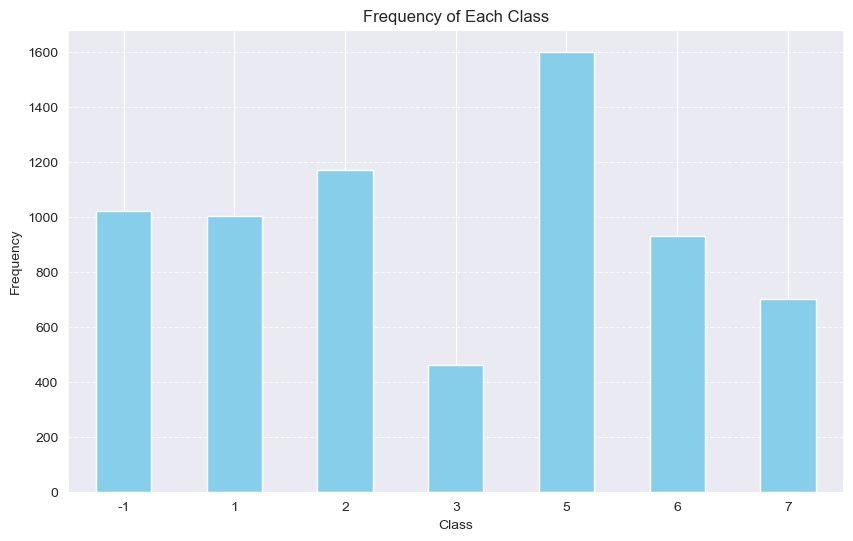

In [35]:
# Plotting the histogram of the frequency of each class including -1
plt.figure(figsize=(10, 6))
df['Class'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Frequency of Each Class')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keep the class labels horizontal for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [36]:
df_no_target = df.drop(columns=['Class'])

In [37]:
gower_matrix = gower.gower_matrix(df_no_target)

In [38]:
print(gower_matrix)

[[0.         0.06204601 0.1733871  ... 0.2889611  0.34374708 0.23063426]
 [0.06204601 0.         0.11171145 ... 0.2290952  0.28388116 0.28187945]
 [0.1733871  0.11171145 0.         ... 0.22874232 0.28352827 0.28152657]
 ...
 [0.2889611  0.2290952  0.22874232 ... 0.         0.05718599 0.06063179]
 [0.34374708 0.28388116 0.28352827 ... 0.05718599 0.         0.11455691]
 [0.23063426 0.28187945 0.28152657 ... 0.06063179 0.11455691 0.        ]]


# Agglomerative Clustering

In [39]:
model = AgglomerativeClustering(n_clusters = 7, affinity = 'precomputed')

In [40]:
target = df[['Class']]
le = LabelEncoder()

labeled_target = target.apply(le.fit_transform)

labels = pd.DataFrame()
labels['target'] = labeled_target.values.reshape(1, -1).tolist()[0]


## Trying three different kinds of linkages for agglomerative clustering

### Single Linkage

In [41]:
model_single_linkage = AgglomerativeClustering(n_clusters = 7, linkage= 'single', metric = 'precomputed')
clusters_single_linkage = model_single_linkage.fit_predict(gower_matrix)

In [42]:
labels['single_linkage_predictions'] = clusters_single_linkage

In [43]:
sri = rand_score(labeled_target.values.reshape(1, -1)[0], clusters_single_linkage)
print(f'Rand Index: {sri}')

Rand Index: 0.16064284476804175


<Axes: ylabel='count'>

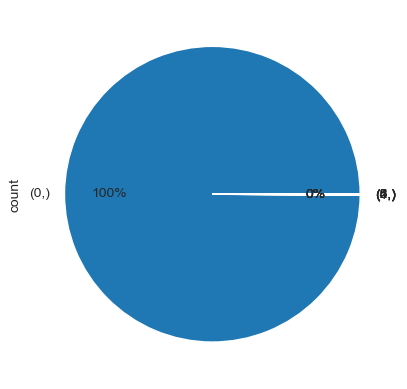

In [44]:
labels[['single_linkage_predictions']].value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)

This shows that all the data has fallen under one cluster. This is not a good representation of the data

## Average Clustering

In [45]:
model_average_linkage = AgglomerativeClustering(n_clusters = 7, linkage = 'average', affinity = 'precomputed')
clusters_average_linkage = model_average_linkage.fit_predict(gower_matrix)

C:\Tools\conda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [46]:
labels['average_linkage_predictions'] = clusters_average_linkage

In [47]:
ari = rand_score(labeled_target.values.reshape(1, -1)[0], clusters_average_linkage)
print(f'Rand Index: {ari}')

Rand Index: 0.2866094234297379


<Axes: ylabel='count'>

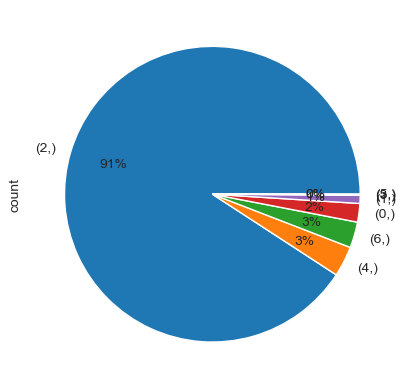

In [48]:
labels[['average_linkage_predictions']].value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)

The number of classes representing each type of data is diversifying but still the classes are being represented well.

## Complete Linkage

In [49]:
model_complete_linkage = AgglomerativeClustering(n_clusters=7, linkage = 'complete', affinity= 'precomputed')
clusters_complete_linkage = model_complete_linkage.fit_predict(gower_matrix)

C:\Tools\conda\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [50]:
labels['complete_linkage_predictions'] = clusters_complete_linkage

In [51]:
cri = rand_score(labeled_target.values.reshape(1, -1)[0], clusters_complete_linkage)
print(f'Rand Index: {cri}')

Rand Index: 0.6514787555462124


<Axes: ylabel='count'>

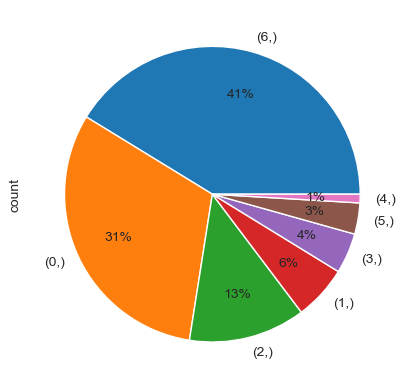

In [66]:
labels[['complete_linkage_predictions']].value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)

In [53]:
labels.value_counts(["target", "complete_linkage_predictions"])

target  complete_linkage_predictions
4       6                               605
        0                               560
1       6                               513
2       6                               506
        0                               443
0       6                               440
5       6                               374
4       2                               358
5       0                               335
1       0                               325
0       0                               277
6       6                               257
3       5                               175
6       0                               171
0       2                               149
3       6                               148
6       1                               140
5       1                               112
1       2                               105
0       1                               100
6       2                                82
2       2                              

In [54]:
labels['aligned_clusters'] = labels['complete_linkage_predictions'].apply(lambda x: int(not x))

ValueError: `data` and `annot` must have same shape.

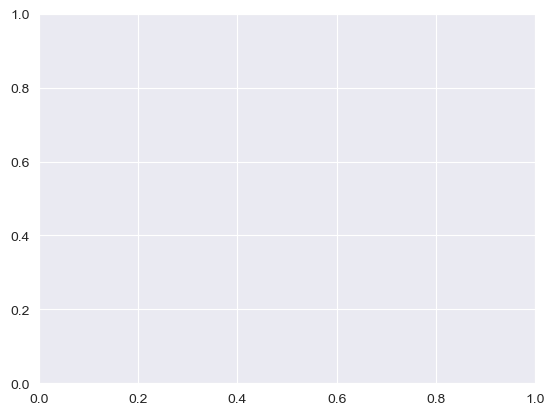

In [55]:
cf_matrix = confusion_matrix(labeled_target.values, labels[["aligned_clusters"]].values)
cf_labels = ['True Neg','False Pos','False Neg','True Pos']
fig, ax = plt.subplots(1, 1)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=cf_labels, fmt='', cmap='Blues')
ax.set_ylabel('Target Labels')
ax.set_xlabel('Predicted Labels')

# Classification

In [72]:
df_target = df[['Class']]
df_no_target.head()

,BallAcceleration,Time,DistanceWall,DistanceCeil,DistanceBall,PlayerSpeed,BallSpeed,up,accelerate,slow,goal,left,boost,camera,down,right,slide,jump
0,1636.798772,0.000000,3498.01,2012.98,299.668270,104267.426232,99035.849338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,3198.029397,0.138893,3494.08,2012.98,229.896780,124248.031988,102233.878734,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,0.000000,0.173617,3494.08,2012.98,237.350599,124248.031988,102968.358990,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,9914.766242,0.312510,3500.08,2012.98,151.880921,115248.016009,112883.125231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5907.747166,0.625019,3521.65,2013.00,154.556104,125091.256173,118790.872398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [87]:
# train test split data 80%-20%

X = df_no_target
y = df['Class']

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Desicion Tree Classifier

In [141]:
dtree = DecisionTreeClassifier(max_depth = 10000).fit(X_train, y_train)
dtree_prediction = dtree.predict(X_test)

In [142]:
cm = confusion_matrix(y_test, dtree_prediction)

In [147]:
cm_graph = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)

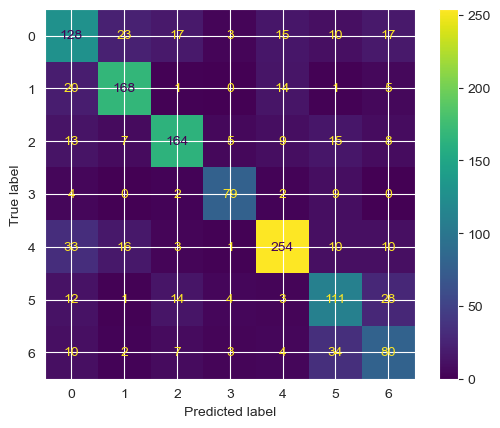

In [148]:
cm_graph.plot()
plt.show()

In [149]:
accuracy = metrics.accuracy_score(y_test, dtree_prediction)
print(accuracy)

0.7135605511240029


In [154]:
precision = metrics.precision_score(y_test, dtree_prediction, average='weighted')
print(precision)

0.7197241474629441


In [155]:
sensitivity_recall = metrics.recall_score(y_test, dtree_prediction, average='weighted')
print(sensitivity_recall)

0.7135605511240029
